# Lecture 7 - Barren plateaus 

#### Quantum Data Science 23/24

### Table of Contents

1. [Barren plateau interlude](#barren_plateau_interlude)
2. [Barren plateau in a randomized ansatz](#barren_plateau_pauli2design)
3. [Barren plateau in depth-1 ansatz](#barren_plateau_depth1)
4. [Hands on exercise](#hands_on_exercise)
5. [References](#references)

### 1. Barren plateau interlude <a id='barren_plateau_interlude'></a>

Barren plateaus (BPs) are characterized by flat cost landscapes, which means that the gradient of the cost function is zero everywhere. This is a problem for gradient-based optimization methods, which are the most common methods used to train quantum neural networks, since they cannot find a direction to move in.

<p align="center">

<img src="images/barren plateaus.png" alt="drawing" height=400 width="400"/>

</p>

In the context of PQC optimization using gradient-based methods, the BP problem is caused by the depth of the model, same as classical neural networks in which the model cannot backpropagate the gradient signal. In addition, gradients in PQC vanish with the number of qubits (width) as well. A BP in a PQC-based cost function $C(\theta)$ is rigorously defined as a region of the parameter space where the partial derivative of the cost function w.r.t a parameter $\theta_i$ uniformly sampled is zero on average:
$$
\mathbb{E}\left[\frac{\partial C(\theta)}{\partial \theta_{i}}\right]=0 
$$

Therefore, it is common to look at the scaling of the variance of the cost function's partial derivative. It is said that in a BP, the variance of the gradient vanishes exponentially with the number of qubits as:
$$
\mathbb{V}\left[\frac{\partial C(\theta)}{\partial \theta_{i}}\right] \in \mathcal{O}\left(\frac{1}{\alpha^{n}}\right)
$$
where $n$ is the number of qubits and $\alpha > 1$.


In this setting, since $\mathbb{E}\left[\frac{\partial C(\theta)}{\partial \theta_{i}}\right]=0$, from the Chebyshev’s inequality, the variance of
partial derivatives tells us that in a BP, the gradient become exponentially concentrated in its average value of zero.


#### Main sources of BPs:

1. **Random ansatz**: Ansatz is constructed by randomly choosing the gates and their parameters. In this case, the gradient of the cost function is zero on average [Mcclean et al. 2018](https://arxiv.org/abs/1803.11173) using a global measureament.
2. **entanglement induced**: BPs are induced by highly entangled states [Marrero et.al 2021](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.040316)
3. **Noise induced**: BPs are induced by local Pauli noise in generic ansatzes like Quantum Alternating Operator Ansatz (QAOA) and Unitary coupled cluster (UCCSD) [Wang et.al](https://www.nature.com/articles/s41467-021-27045-6)

<p align="center">

<img src="images/sources_BPS.png" alt="drawing" height=400 width="400"/>

</p>

#### Avoiding BPs:

1. **Shallow circuits with local measurements**: Random circuits with local measurements can be trained in $\mathcal{O}(\text{poly}(log(n))) depth$ [Cerezo et al. 2020](https://arxiv.org/abs/2001.00550).
2. **Layerwise training**: Training the circuit layer by layer [Skolik et.al 2020](https://arxiv.org/abs/2006.14904).
3. **Initialization**: Initialization blocks of the circuit at identity to remove expressivity [Grant et.al 2019](https://arxiv.org/abs/1903.05076).
4. **Quantum convolutional neural networks**: Quantum convolutional neural networks (QCNNs) are a class of quantum neural networks inspired by classical convolutional neural networks (CNNs) that avoid BPs due to their shallow depth [Pesah et.al 2021](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.11.041011).

It is important to refer that that BPs are a deep problem in the trainability of PQC-based models. It seems that circuits or strategies alleviating BPs at the moment are the ones that lead also to classical simulability of such models [Cerezo et.al 2023](https://arxiv.org/abs/2312.09121)!! 

### 2. Barren plateau in a randomized ansatz <a id='barren_plateau_pauli2design'></a>

##### imports

In [2]:
import qiskit
from qiskit import *
import numpy as np
import matplotlib.pyplot as plt

from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.circuit.library import PauliTwoDesign
from qiskit_machine_learning.circuit.library import QNNCircuit

The [PauliTwoDesign](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.PauliTwoDesign) ansatz implements a particular form of a 2-design circuit frequently studied in quantum machine learning literature for the study of BPs.

```python
     ┌─────────┐┌──────────┐       ░ ┌──────────┐       ░  ┌──────────┐
q_0: ┤ RY(π/4) ├┤ RZ(θ[0]) ├─■─────░─┤ RY(θ[4]) ├─■─────░──┤ RZ(θ[8]) ├
     ├─────────┤├──────────┤ │     ░ ├──────────┤ │     ░  ├──────────┤
q_1: ┤ RY(π/4) ├┤ RZ(θ[1]) ├─■──■──░─┤ RY(θ[5]) ├─■──■──░──┤ RX(θ[9]) ├
     ├─────────┤├──────────┤    │  ░ ├──────────┤    │  ░ ┌┴──────────┤
q_2: ┤ RY(π/4) ├┤ RX(θ[2]) ├─■──■──░─┤ RY(θ[6]) ├─■──■──░─┤ RX(θ[10]) ├
     ├─────────┤├──────────┤ │     ░ ├──────────┤ │     ░ ├───────────┤
q_3: ┤ RY(π/4) ├┤ RZ(θ[3]) ├─■─────░─┤ RX(θ[7]) ├─■─────░─┤ RY(θ[11]) ├
     └─────────┘└──────────┘       ░ └──────────┘       ░ └───────────┘

```
Keep in mind that setting a different seed for generating the circuit will result in a different rotations. 



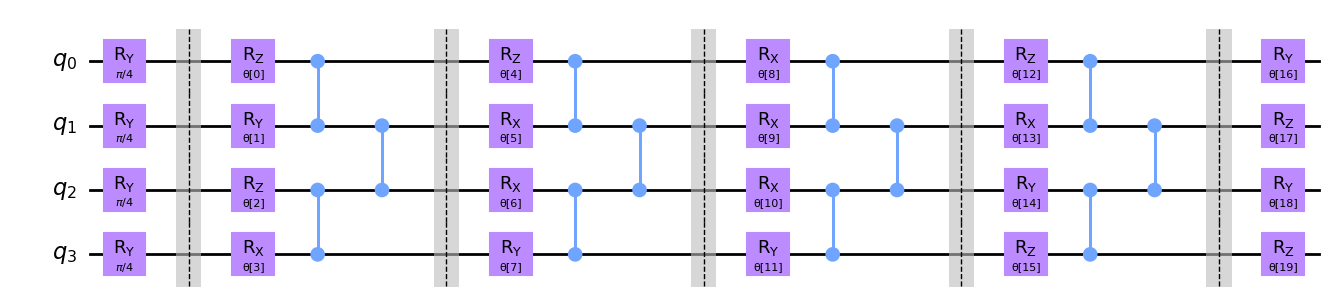

In [9]:
n_qubits = 4
ansatz = PauliTwoDesign(n_qubits, reps=4, insert_barriers=True)

ansatz.decompose().draw(output='mpl')

Let us use the PauliTwoDesign ansatz in a QNNCircuit from qiskit. Let the encoding be the identity encoding and the readout be the expectation value of the global Pauli Z observable $\langle Z^{\otimes n} \rangle$.

We are considering an encoding block just to be easier to do an analysis of BPs as a function of the encoding used.

/opt/homebrew/Caskroom/miniforge/base/envs/CDQ/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


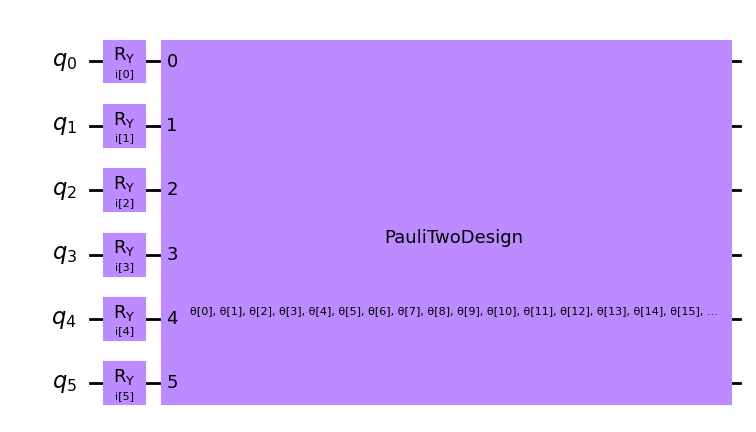

In [10]:
n_qubits = 6

#parameters for the feature map
inputs = qiskit.circuit.ParameterVector("i", n_qubits)

encoding = QuantumCircuit(n_qubits)

for i in range(n_qubits):
    encoding.ry(inputs[i], i)

#encoding.draw(output='mpl')

ansatz = PauliTwoDesign(n_qubits, reps=2, insert_barriers=True)

#QNNCircuit is a wrapper for the feature map and ansatz. Using QNNCircuit is equivalent to explicitly defining the feature map and ansatz
#This way we don't need to define the parameters of the feature map and ansatz separately. See below.
circuit = QNNCircuit(num_qubits=n_qubits, feature_map=encoding, ansatz=ansatz)

#observables=None by default uses the Z^\otimes n global operator 
estimator_qnn = EstimatorQNN(circuit=circuit)


#SAME AS EXPLICITLY DEFINING ENCODING AND ANSATZ
'''
feature_map = encoding
ansatz = ansatz

qc = QuantumCircuit(num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

qnn = EstimatorQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters
)
'''
estimator_qnn.circuit.draw(output='mpl')

In [12]:
#set the random parameters of the feature map and ansatz
#set feature map parameters to 0 to ignore feature map

sampler_qnn_input = np.zeros(estimator_qnn.num_inputs)
sampler_qnn_weights = np.random.uniform(-np.pi,np.pi,estimator_qnn.num_weights)

#### Forward pass 


In [13]:
exp_val = estimator_qnn.forward(sampler_qnn_input, sampler_qnn_weights)
print(exp_val)

[[-0.25770695]]


#### Backward pass to obtain gradients

In [ ]:
sampler_qnn_input_grad, sampler_qnn_weight_grad = estimator_qnn.backward(sampler_qnn_input, sampler_qnn_weights)
print(sampler_qnn_input_grad)
print(sampler_qnn_weight_grad)

Gradients of the input parameters are None because input_gradients are not set.


In [16]:
estimator_qnn.input_gradients = True
exp_val = estimator_qnn.forward(sampler_qnn_input, sampler_qnn_weights)
sampler_qnn_input_grad, sampler_qnn_weight_grad = estimator_qnn.backward(sampler_qnn_input, sampler_qnn_weights)
print(sampler_qnn_input_grad)
print(sampler_qnn_weight_grad)

[[[ 0.1151138  -0.52667829  0.12179515  0.20831711 -0.01199218
   -0.03251289]]]
[[[ 0.03515114  0.06108204 -0.09542821 -0.12471695 -0.01199218
    0.20409495 -0.32835166 -0.07383769  0.0168432  -0.01217299
   -0.01052241  0.08705007 -0.05450984 -0.29526748  0.0168432
    0.31805235  0.03970512  0.08705007]]]


#### Variance of the gradient as a function of the number of qubits 

Define a function to build the quantum neural network as a function of the number of qubits and the depth of the circuit.


In [31]:
from qiskit.primitives import Estimator
from qiskit_algorithms.gradients import SPSAEstimatorGradient, ReverseEstimatorGradient, LinCombEstimatorGradient

def quantum_neural_network(n_qubits=2, depth=1):
    n_qubits = n_qubits

    inputs = qiskit.circuit.ParameterVector("i", n_qubits)

    encoding = QuantumCircuit(n_qubits)

    for i in range(n_qubits):
        encoding.ry(inputs[i], i)

    #encoding.draw(output='mpl')

    ansatz = PauliTwoDesign(n_qubits, reps=depth, insert_barriers=True)

    circuit = QNNCircuit(num_qubits=n_qubits, feature_map=encoding, ansatz=ansatz)

    estimator = Estimator()
    #gradient = LinCombEstimatorGradient(estimator)
    gradient = SPSAEstimatorGradient(estimator,epsilon = 0.1, batch_size=10)
    #gradient = ReverseEstimatorGradient(estimator)

    #observables =None by default uses the Z^\otimes n global operator 
    estimator_qnn = EstimatorQNN(circuit=circuit, gradient=gradient)#, weight_params=[params1[1]])

    return estimator_qnn

Save average and variance of the gradient norm as a function of the number of qubits

In [38]:
qubits = [2,4,6,8,10,12]
samples = 500

norm_gradient = []

means = []
variances = []

for n_qubits in qubits:
    norm_gradient = []
    print("-starting w/ {} qubits".format(n_qubits))
    for s in range(samples):
        print("---starting sample {}".format(s))
        estimator_qnn = quantum_neural_network(n_qubits=n_qubits, depth=1)
        sampler_qnn_input = np.zeros(estimator_qnn.num_inputs)
        sampler_qnn_weights = np.random.uniform(-np.pi,np.pi,estimator_qnn.num_weights)
        exp_val = estimator_qnn.forward(sampler_qnn_input, sampler_qnn_weights)
        sampler_qnn_input_grad, sampler_qnn_weight_grad = estimator_qnn.backward(sampler_qnn_input, sampler_qnn_weights)
        norm_gradient.append(np.linalg.norm(sampler_qnn_weight_grad.flatten(),2))
    means.append(np.mean(norm_gradient))
    variances.append(np.var(norm_gradient))

-starting w/ 2 qubits
---starting sample 0
---starting sample 1
---starting sample 2
---starting sample 3
---starting sample 4
---starting sample 5
---starting sample 6
---starting sample 7
---starting sample 8
---starting sample 9
---starting sample 10
---starting sample 11
---starting sample 12
---starting sample 13
---starting sample 14
---starting sample 15
---starting sample 16
---starting sample 17
---starting sample 18
---starting sample 19
---starting sample 20
---starting sample 21
---starting sample 22
---starting sample 23
---starting sample 24
---starting sample 25
---starting sample 26
---starting sample 27
---starting sample 28
---starting sample 29
---starting sample 30
---starting sample 31
---starting sample 32
---starting sample 33
---starting sample 34
---starting sample 35
---starting sample 36
---starting sample 37
---starting sample 38
---starting sample 39
---starting sample 40
---starting sample 41
---starting sample 42
---starting sample 43
---starting sample 4

#### plot the variance and the mean of the gradient as a function of the number of qubits

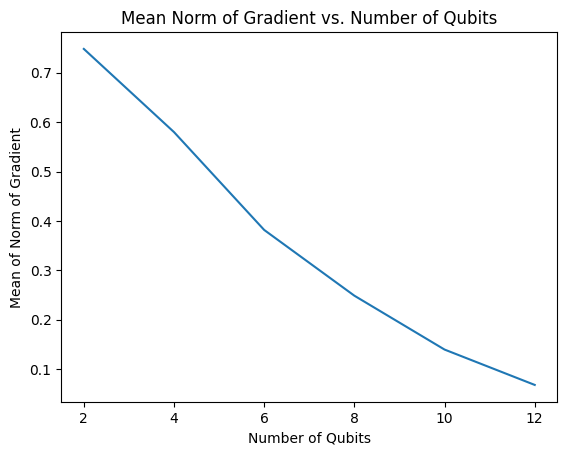

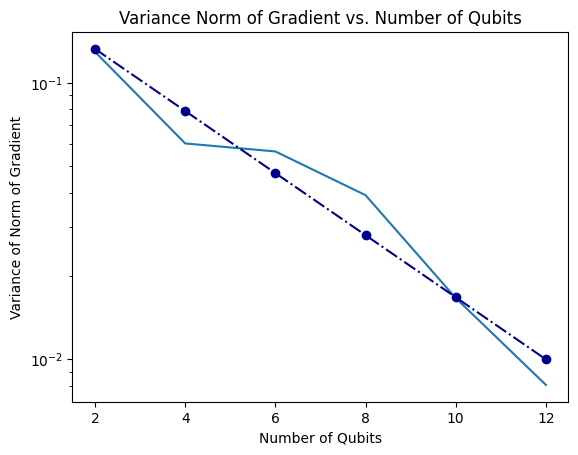

In [37]:
from scipy.optimize import curve_fit

qubits = np.array(qubits)

plt.plot(qubits, means)
plt.xlabel("Number of Qubits")
plt.ylabel("Mean of Norm of Gradient")
plt.title("Mean Norm of Gradient vs. Number of Qubits")
plt.show()

plt.plot(qubits, variances)

p = np.polyfit(qubits, np.log(variances), 1)
plt.semilogy(qubits, np.exp(p[0] * np.array(qubits) + p[1]), "o-.", color="darkblue")

plt.xlabel("Number of Qubits")
plt.ylabel("Variance of Norm of Gradient")
plt.title("Variance Norm of Gradient vs. Number of Qubits")
plt.show()


In [26]:
import qiskit
from qiskit import *
import matplotlib.pyplot as plt
import numpy as np
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit.circuit.library import PauliTwoDesign
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.primitives import Estimator
from qiskit_algorithms.gradients import SPSAEstimatorGradient, SPSASamplerGradient, LinCombSamplerGradient

### 3. Barren plateau in depth-1 ansatz <a id='barren_plateau_depth1'></a>

Suppose we have a simple product state composed of $\sigma_y$ rotations. 

$$
\vert \psi (\theta) \rangle = \otimes_{i=0}^{n-1} R_y(\theta_i) \vert 0 \rangle_i
$$

Suppose our cost function is the probability of measuring the all-zero state $\vert 0 \rangle$ in the computational basis. The observable is the projector onto the all-zero state $\vert 0 \rangle \langle 0 \vert^{\otimes n}$.

$$
C(\theta) = |\langle 0 | \psi (\theta) \rangle |^2
$$

Such a cost-function, even though comprised of a product state of depth 1 suffer from the barren plateau phenomenon.

In [83]:

def quantum_neural_network(n_qubits):
    n_qubits = n_qubits

    inputs = qiskit.circuit.ParameterVector("i", n_qubits)
    weights = qiskit.circuit.ParameterVector("w", n_qubits)

    encoding = QuantumCircuit(n_qubits)
    ansatz = QuantumCircuit(n_qubits)

    for i in range(n_qubits):
        encoding.rx(inputs[i], i)
        ansatz.ry(weights[i], i)

    circuit = QNNCircuit(num_qubits=n_qubits, feature_map=encoding, ansatz=ansatz)

    estimator = Estimator()
    #gradient = SPSAEstimatorGradient(estimator,epsilon = 0.001, batch_size=10)
    #gradient = ReverseEstimatorGradient(estimator,epsilon = 0.001, batch_size=10)

    estimator = Estimator()
    #gradient = SPSASamplerGradient(estimator,epsilon = 0.001, batch_size=10)
    gradient = LinCombSamplerGradient(estimator)
 
    def all_zero(x):
        if bin(x).count("0") == n_qubits:
            return 0
        else:
            return 1

    #observables =None by default uses the Z^\otimes n global operator 
    sampler_qnn = SamplerQNN(circuit=circuit, interpret=all_zero, output_shape=2)#, gradient=gradient)

    return sampler_qnn

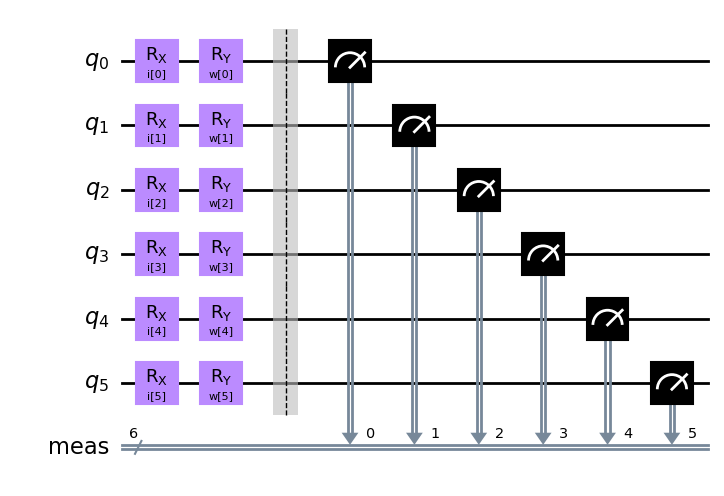

In [84]:
n_qubits = 6
sampler_qnn_ = quantum_neural_network(n_qubits)

sampler_qnn_.circuit.draw(output='mpl')  

In [85]:
sampler_qnn_input = np.zeros(sampler_qnn_.num_inputs)
sampler_qnn_weights = np.random.uniform(-np.pi,np.pi,sampler_qnn_.num_weights)

probs = sampler_qnn_.forward(sampler_qnn_input, sampler_qnn_weights)

print("probabilities:\n",probs)

sampler_qnn_input_grad, sampler_qnn_weight_grad = sampler_qnn_.backward(sampler_qnn_input, sampler_qnn_weights)

print("weight gradient:\n",sampler_qnn_weight_grad)


probabilities:
 [[0.16656085 0.83343915]]
weight gradient:
 [[[ 0.02903714 -0.02641642  0.0190226   0.28907993  0.04439698
   -0.09207691]
  [-0.02903714  0.02641642 -0.0190226  -0.28907993 -0.04439698
    0.09207691]]]


In [87]:
qubits = [2,4,6,8,10,12]
samples = 200

norm_gradient = []

means = []
variances = []

for n_qubits in qubits:
    norm_gradient = []
    print("-starting w/ {} qubits".format(n_qubits))
    for s in range(samples):
        print("---starting sample {}".format(s))
        estimator_qnn = quantum_neural_network(n_qubits)
        sampler_qnn_input = np.zeros(estimator_qnn.num_inputs)
        sampler_qnn_weights = np.random.uniform(-np.pi,np.pi,estimator_qnn.num_weights)
        exp_val = estimator_qnn.forward(sampler_qnn_input, sampler_qnn_weights)
        sampler_qnn_input_grad, sampler_qnn_weight_grad = estimator_qnn.backward(sampler_qnn_input, sampler_qnn_weights)
        norm_gradient.append(np.linalg.norm(sampler_qnn_weight_grad[0].flatten(),2))
    means.append(np.mean(norm_gradient))
    variances.append(np.var(norm_gradient))

-starting w/ 2 qubits
---starting sample 0
---starting sample 1
---starting sample 2
---starting sample 3
---starting sample 4
---starting sample 5
---starting sample 6
---starting sample 7
---starting sample 8
---starting sample 9
---starting sample 10
---starting sample 11
---starting sample 12
---starting sample 13
---starting sample 14
---starting sample 15
---starting sample 16
---starting sample 17
---starting sample 18
---starting sample 19
---starting sample 20
---starting sample 21
---starting sample 22
---starting sample 23
---starting sample 24
---starting sample 25
---starting sample 26
---starting sample 27
---starting sample 28
---starting sample 29
---starting sample 30
---starting sample 31
---starting sample 32
---starting sample 33
---starting sample 34
---starting sample 35
---starting sample 36
---starting sample 37
---starting sample 38
---starting sample 39
---starting sample 40
---starting sample 41
---starting sample 42
---starting sample 43
---starting sample 4

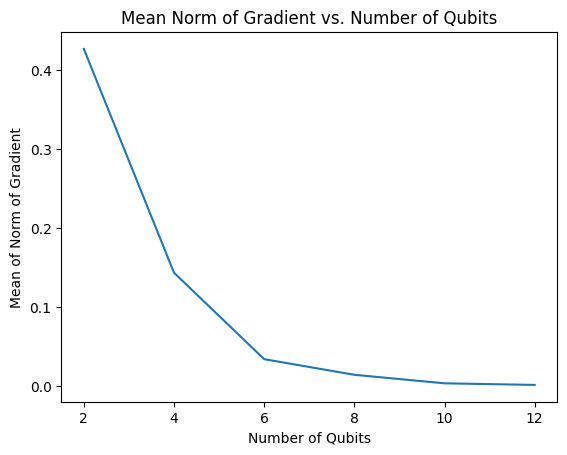

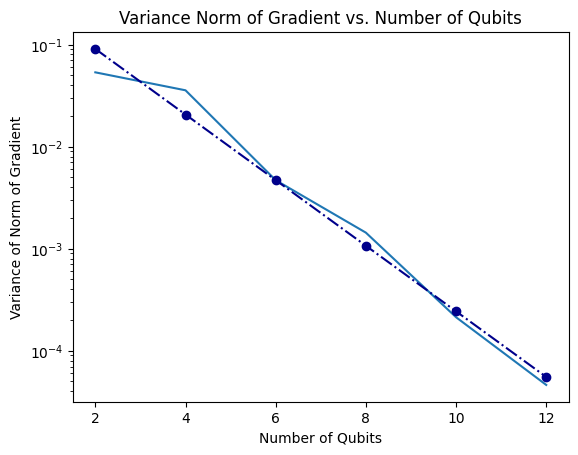

In [88]:
from scipy.optimize import curve_fit

qubits = np.array(qubits)

plt.plot(qubits, means)
plt.xlabel("Number of Qubits")
plt.ylabel("Mean of Norm of Gradient")
plt.title("Mean Norm of Gradient vs. Number of Qubits")
plt.show()

plt.plot(qubits, variances)

p = np.polyfit(qubits, np.log(variances), 1)
plt.semilogy(qubits, np.exp(p[0] * np.array(qubits) + p[1]), "o-.", color="darkblue")

plt.xlabel("Number of Qubits")
plt.ylabel("Variance of Norm of Gradient")
plt.title("Variance Norm of Gradient vs. Number of Qubits")
plt.show()


Even though the PQC is a product state with depth 1, we are measuring the probability of a basis state. Notice that such probabilities become exponentially small with the number of qubits, on their own. Therefore, PQC-based generative training will always suffer from the barren plateau phenomenon. Moreover, as the number of qubits increases, the probabilities will actually concentrate!! [Rudolph et.al](https://arxiv.org/abs/2305.02881)

### 4. Hands on exercise <a id='hands_on_exercise'></a>

1. Study the BP phenonmeon in QNNs using an harware efficient ansatz with global measurements.


In [23]:
### Your code here ###

2. Study the BP phenonmeon in QNNs using a random anstatz with local measurements. Measure a single-qubit.

In [44]:
### Your code here ###

### 5. References <a id='references'></a>
1. Machine learning with quantum computers [Schuld et.al 2021](https://link.springer.com/book/10.1007/978-3-030-83098-4)
1. Barren plateaus in the trainability of quantum nerual network landscapes [McClean et al. 2018](https://arxiv.org/abs/1803.11173)
2. Cost-function dependent barren plateaus in shallow parametrized quantum circuits [Cerezo et.al 2020](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.040316)
3. Noise-induced barren plateaus [Wang et.al 2021](https://www.nature.com/articles/s41467-021-27045-6)
4. Trainability barriers and opportunities in quantum generative modelling [Rudolph et.al 2023](https://arxiv.org/abs/2305.02881) 
5. Does provable absence of barren plateaus imply classical simulability? Or, why we need to rethink variational quantum computing [Cerezo et.al 2023](https://arxiv.org/abs/2312.09121)
6. Quantum Neural Networks using Qiskit [Qiskit QNN module](https://qiskit.org/ecosystem/machine-learning/tutorials/01_neural_networks.html)